In [8]:
import serial
import re
import time as py_time # Alias time to avoid potential conflicts

# --- Configuration ---
SERIAL_PORT = 'COM14'  # <--- !!! IMPORTANT: CHANGE THIS TO YOUR ARDUINO'S SERIAL PORT !!!
BAUD_RATE = 9600
# For characterization, we're waiting for Arduino to finish, not collecting a fixed number of points
# MAX_DATA_POINTS is not strictly used in this loop, but good to keep in mind for long runs

# --- Data Storage (these will be global lists) ---
pwms = []
rpms_left = []
rpms_right = []

print(f"--- Starting Data Collection from {SERIAL_PORT} ---")

ser = None # Initialize serial object outside try block
try:
    ser = serial.Serial(SERIAL_PORT, BAUD_RATE, timeout=1)
    py_time.sleep(2) # Give some time for Arduino to reset and start

    # Clear any initial buffer messages
    while ser.in_waiting > 0:
        ser.readline()

    print("Listening for data...")
    data_started = True
    
    while True: # Loop indefinitely until "Characterization Complete" or interrupted
        if ser.in_waiting > 0:
            line = ser.readline().decode('utf-8', errors='ignore').strip()
            print(f"Received: {line}") # Uncomment for debugging received lines

            if "Characterization Complete" in line:
                print("\n--- Characterization Complete. Stopping data collection. ---")
                break # Exit the loop when characterization is done

            if "PWM,RPM_Left,RPM_Right" in line:
                data_started = True
                print("Header received. Starting data parsing.")
                continue # Skip the header line

            if data_started:
                # Regex to match "PWM,RPM_Left,RPM_Right" format
                match = re.match(r'(\d+),([\d.]+),([\d.]+)', line)
                if match:
                    try:
                        pwm_val = int(match.group(1))
                        rpm_left_val = float(match.group(2))
                        rpm_right_val = float(match.group(3))

                        pwms.append(pwm_val)
                        rpms_left.append(rpm_left_val)
                        rpms_right.append(rpm_right_val)

                        # print(f"Collected: PWM={pwm_val}, RPM_L={rpm_left_val}, RPM_R={rpm_right_val}")
                    except ValueError as e:
                        print(f"Error parsing values from line: '{line}' - {e}")
                elif "Applying PWM:" in line:
                    # Ignore these lines, they are progress updates
                    pass
                else:
                    # print(f"Ignoring unmatched line: {line}") # Debugging for unexpected lines
                    pass
        py_time.sleep(0.01) # Small delay to prevent busy-waiting

except serial.SerialException as e:
    print(f"\nSerial port error: {e}")
except KeyboardInterrupt:
    print("\nData collection interrupted by user.")
    ser.close()
finally:
    if ser and ser.is_open:
        ser.close()
        print("Serial port closed.")
    print(f"--- Data Collection Complete. Collected {len(pwms)} data points. ---")

--- Starting Data Collection from COM14 ---
Listening for data...
Received: PWM,RPM_Left,RPM_Right
Header received. Starting data parsing.
Received: Applying PWM: 0
Received: 0,25.00,25.00
Received: Applying PWM: 5
Received: 5,25.00,25.00
Received: Applying PWM: 10
Received: 10,25.00,25.00
Received: Applying PWM: 15
Received: 15,25.00,25.00
Received: Applying PWM: 20
Received: 20,25.00,25.00
Received: Applying PWM: 25
Received: 25,25.00,25.00
Received: Applying PWM: 30
Received: 30,25.00,25.00
Received: Applying PWM: 35
Received: 35,25.00,25.00
Received: Applying PWM: 40
Received: 40,25.00,25.00
Received: Applying PWM: 45
Received: 45,25.00,25.00
Received: Applying PWM: 50
Received: 50,25.00,25.00
Received: Applying PWM: 55
Received: 55,50.00,25.00
Received: Applying PWM: 60
Received: 60,50.00,25.00
Received: Applying PWM: 65
Received: 65,50.00,50.00
Received: Applying PWM: 70
Received: 70,50.00,50.00
Received: Applying PWM: 75
Received: 75,75.00,50.00
Received: Applying PWM: 80
Receiv

Left Motor Regression: RPM = 0.7528 * PWM + 10.2685
Right Motor Regression: RPM = 0.7180 * PWM + 11.3389


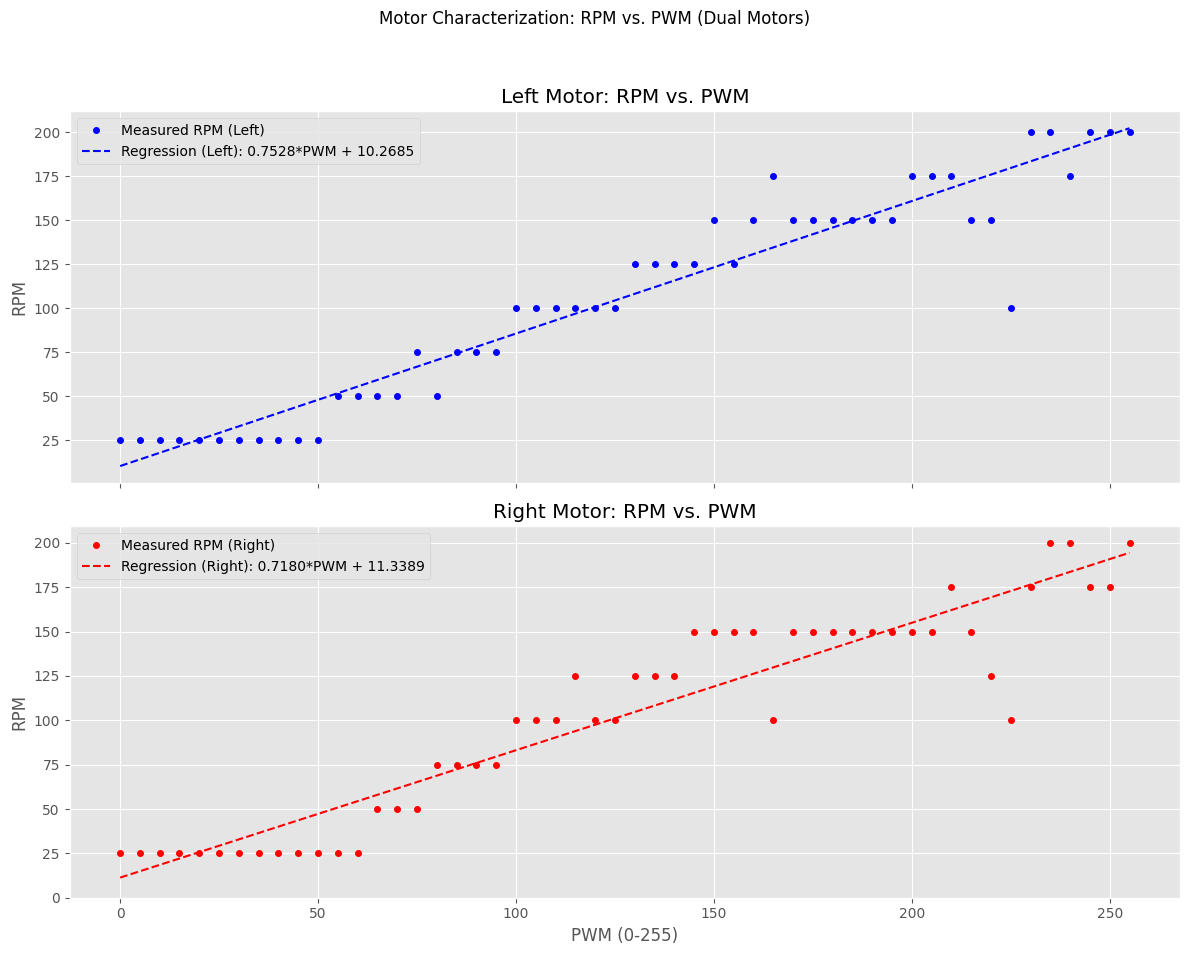

Plot generated with 52 data points.


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# --- Plot Configuration ---
# Assuming these are for your characterization, not PID loop.
# The x-axis is PWM, so ARDUINO_LOOP_INTERVAL_MS is not directly used for x-axis scaling here.

# --- Plot Setup ---
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True) # Two subplots, sharing the X-axis
fig.suptitle('Motor Characterization: RPM vs. PWM (Dual Motors)')

# Convert lists to NumPy arrays for easier manipulation
pwms_np = np.array(pwms).reshape(-1, 1) # Reshape for sklearn
rpms_left_np = np.array(rpms_left)
rpms_right_np = np.array(rpms_right)

# Filter out 0 RPM values for linear regression (optional, but improves fit for effective range)
# Identify where RPM is non-zero for Left motor
non_zero_rpm_indices_left = rpms_left_np > 0
pwms_filtered_left = pwms_np[non_zero_rpm_indices_left]
rpms_filtered_left = rpms_left_np[non_zero_rpm_indices_left]

# Identify where RPM is non-zero for Right motor
non_zero_rpm_indices_right = rpms_right_np > 0
pwms_filtered_right = pwms_np[non_zero_rpm_indices_right]
rpms_filtered_right = rpms_right_np[non_zero_rpm_indices_right]

# --- Linear Regression for Left Motor ---
if len(pwms_filtered_left) > 1:
    reg_left = LinearRegression()
    reg_left.fit(pwms_filtered_left, rpms_filtered_left)
    slope_left = reg_left.coef_[0]
    intercept_left = reg_left.intercept_
    print(f"Left Motor Regression: RPM = {slope_left:.4f} * PWM + {intercept_left:.4f}")
    # Predict RPM values for plotting the regression line
    predicted_rpms_left = reg_left.predict(pwms_np)
else:
    print("Not enough non-zero RPM data for Left Motor regression.")
    slope_left = 0
    intercept_left = 0
    predicted_rpms_left = np.zeros_like(pwms_np)


# --- Linear Regression for Right Motor ---
if len(pwms_filtered_right) > 1:
    reg_right = LinearRegression()
    reg_right.fit(pwms_filtered_right, rpms_filtered_right)
    slope_right = reg_right.coef_[0]
    intercept_right = reg_right.intercept_
    print(f"Right Motor Regression: RPM = {slope_right:.4f} * PWM + {intercept_right:.4f}")
    # Predict RPM values for plotting the regression line
    predicted_rpms_right = reg_right.predict(pwms_np)
else:
    print("Not enough non-zero RPM data for Right Motor regression.")
    slope_right = 0
    intercept_right = 0
    predicted_rpms_right = np.zeros_like(pwms_np)


# --- Plotting ---

# First subplot: RPM_Left vs PWM
ax1.plot(pwms, rpms_left, 'bo', markersize=4, label='Measured RPM (Left)')
ax1.plot(pwms, predicted_rpms_left, 'b--', label=f'Regression (Left): {slope_left:.4f}*PWM + {intercept_left:.4f}')
ax1.set_ylabel('RPM')
ax1.set_title('Left Motor: RPM vs. PWM')
ax1.legend()
ax1.grid(True)

# Second subplot: RPM_Right vs PWM
ax2.plot(pwms, rpms_right, 'ro', markersize=4, label='Measured RPM (Right)')
ax2.plot(pwms, predicted_rpms_right, 'r--', label=f'Regression (Right): {slope_right:.4f}*PWM + {intercept_right:.4f}')
ax2.set_xlabel('PWM (0-255)')
ax2.set_ylabel('RPM')
ax2.set_title('Right Motor: RPM vs. PWM')
ax2.set_ylim(bottom=0) # Ensure Y-axis starts from 0
ax2.legend()
ax2.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

print(f"Plot generated with {len(pwms)} data points.")
if len(pwms) == 0:
    print("No data was collected. Ensure Arduino is running the correct sketch and Cell 1 ran successfully.")

In [22]:
# --- Linear Regression for Left Motor ---
if len(pwms_filtered_left) > 1:
    reg_left = LinearRegression()
    reg_left.fit(pwms_filtered_left, rpms_filtered_left)
    slope_left = reg_left.coef_[0]
    intercept_left = reg_left.intercept_
    print(f"Left Motor Regression: RPM = {slope_left:.4f} * PWM + {intercept_left:.4f}")
    # Predict RPM values only for filtered PWMs
    predicted_rpms_left = reg_left.predict(pwms_filtered_left)
else:
    print("Not enough non-zero RPM data for Left Motor regression.")
    slope_left = 0
    intercept_left = 0
    predicted_rpms_left = np.zeros_like(pwms_filtered_left)


# --- Linear Regression for Right Motor ---
if len(pwms_filtered_right) > 1:
    reg_right = LinearRegression()
    reg_right.fit(pwms_filtered_right, rpms_filtered_right)
    slope_right = reg_right.coef_[0]
    intercept_right = reg_right.intercept_
    print(f"Right Motor Regression: RPM = {slope_right:.4f} * PWM + {intercept_right:.4f}")
    # Predict RPM values only for filtered PWMs
    predicted_rpms_right = reg_right.predict(pwms_filtered_right)
else:
    print("Not enough non-zero RPM data for Right Motor regression.")
    slope_right = 0
    intercept_right = 0
    predicted_rpms_right = np.zeros_like(pwms_filtered_right)


# --- Plotting ---
# First subplot: RPM_Left vs PWM
ax1.plot(pwms, rpms_left, 'bo', markersize=4, label='Measured RPM (Left)')
ax1.plot(pwms_filtered_left, predicted_rpms_left, 'b--',
         label=f'Regression (Left): {slope_left:.4f}*PWM + {intercept_left:.4f}')
ax1.set_ylabel('RPM')
ax1.set_title('Left Motor: RPM vs. PWM')
ax1.legend()
ax1.grid(True)

# Second subplot: RPM_Right vs PWM
ax2.plot(pwms, rpms_right, 'ro', markersize=4, label='Measured RPM (Right)')
ax2.plot(pwms_filtered_right, predicted_rpms_right, 'r--',
         label=f'Regression (Right): {slope_right:.4f}*PWM + {intercept_right:.4f}')
ax2.set_xlabel('PWM (0-255)')
ax2.set_ylabel('RPM')
ax2.set_title('Right Motor: RPM vs. PWM')
ax2.set_ylim(bottom=0)
ax2.legend()
ax2.grid(True)


Left Motor Regression: RPM = 0.2957 * PWM + 4.9861
Right Motor Regression: RPM = 0.3041 * PWM + 3.8851


## loaded both velocity control

In [8]:
import serial
import time
from IPython.display import display, clear_output

# --- Configuration ---
COM_PORT = 'COM8' # !!! IMPORTANT: CHANGE THIS TO YOUR HC-05's ACTUAL COM PORT !!!
BAUD_RATE = 9600  # Must match Arduino's Serial1.begin() baud rate

# --- Global Data Containers for all collected data ---
# These lists will store data that Cell 2 can then access
global_time_data = []
global_rpm_left_data = []
global_pwm_left_data = []
global_rpm_right_data = []
global_pwm_right_data = []

# --- Serial Connection ---
ser = None # Initialize serial object to None
print(f"Attempting to connect to HC-05 on: {COM_PORT} at {BAUD_RATE} baud...")
try:
    ser = serial.Serial(COM_PORT, BAUD_RATE, timeout=0.1) # Short timeout for non-blocking read
    print(f"Successfully connected to HC-05 on: {COM_PORT}")
    print("\n--- Starting Data Acquisition ---")
    print("Format: Timestamp_ms_relative, RPM_L, PWM_L, RPM_R, PWM_R")
    print("Press Ctrl+C to stop data collection.")

    start_time_ms = 0 # To normalize Arduino's millis() timestamp

    while True:
        if ser.in_waiting > 0:
            try:
                line = ser.readline().decode('utf-8').strip()
                
                parts = line.split(',')
                if len(parts) == 5:
                    timestamp_ms = int(parts[0])
                    rpm_l = float(parts[1])
                    pwm_l = int(parts[2])
                    rpm_r = float(parts[3])
                    pwm_r = int(parts[4])

                    if start_time_ms == 0: # Set initial timestamp for relative time
                        start_time_ms = timestamp_ms

                    relative_time_ms = timestamp_ms - start_time_ms

                    # Append data to global lists
                    global_time_data.append(relative_time_ms)
                    global_rpm_left_data.append(rpm_l)
                    global_pwm_left_data.append(pwm_l)
                    global_rpm_right_data.append(rpm_r)
                    global_pwm_right_data.append(pwm_r)

                    # Print data to console (Jupyter cell output)
                    print(f"{relative_time_ms},{rpm_l:.2f},{pwm_l},{rpm_r:.2f},{pwm_r}")

            except ValueError as ve:
                # This can happen if a partial line is received or corrupted data
                print(f"Error parsing line: '{line}' - {ve}")
            except UnicodeDecodeError as ude:
                # This happens with corrupted bytes (e.g., baud rate mismatch initially)
                print(f"UnicodeDecodeError: {ude} - Problematic bytes: {ser.readline()}")
            except Exception as e:
                # Catch any other unexpected errors
                print(f"An unexpected error occurred during data processing: {e}")
                
        time.sleep(0.01) # Small delay to avoid busy-waiting and allow CPU for other tasks

except serial.SerialException as e:
    print(f"\nSerial port error: {e}")
    print(f"Please ensure {COM_PORT} is the correct port and it's not already in use.")
    print("Ensure HC-05 is powered, paired, and its 'Serial Port (SPP)' service is enabled in 'Devices and Printers'.")
except KeyboardInterrupt:
    print("\n--- Data collection stopped by user. ---")
finally:
    if ser and ser.is_open:
        ser.close()
        print("Serial port closed.")
    print(f"Collected {len(global_time_data)} data points.")
    print("\nProceed to the next cell for plotting.")



Attempting to connect to HC-05 on: COM8 at 9600 baud...
Successfully connected to HC-05 on: COM8

--- Starting Data Acquisition ---
Format: Timestamp_ms_relative, RPM_L, PWM_L, RPM_R, PWM_R
Press Ctrl+C to stop data collection.
0,0.00,255,0.00,255
500,0.00,255,0.00,255
1000,0.00,255,0.00,255
1500,0.00,255,0.00,255
2000,0.00,255,0.00,255
2500,0.00,255,0.00,255
3000,0.00,255,0.00,255
3500,0.00,255,0.00,255
4000,0.00,255,0.00,255
4500,0.00,255,0.00,255
5000,0.00,255,0.00,255
5500,0.00,255,0.00,255
6000,0.00,255,0.00,255
6500,0.00,255,0.00,255
7000,0.00,255,0.00,255
7500,0.00,255,0.00,255
8000,0.00,255,0.00,255
8500,0.00,255,0.00,255
9000,0.00,255,0.00,255
9500,0.00,255,0.00,255
10000,0.00,255,0.00,255
10500,0.00,255,0.00,255
11000,0.00,255,0.00,255
11500,0.00,255,0.00,255
12000,0.00,255,0.00,255
12500,0.00,255,0.00,255
13000,0.00,255,0.00,255
13500,0.00,255,0.00,255

--- Data collection stopped by user. ---
Serial port closed.
Collected 28 data points.

Proceed to the next cell for plotti

Plotting 804 data points...


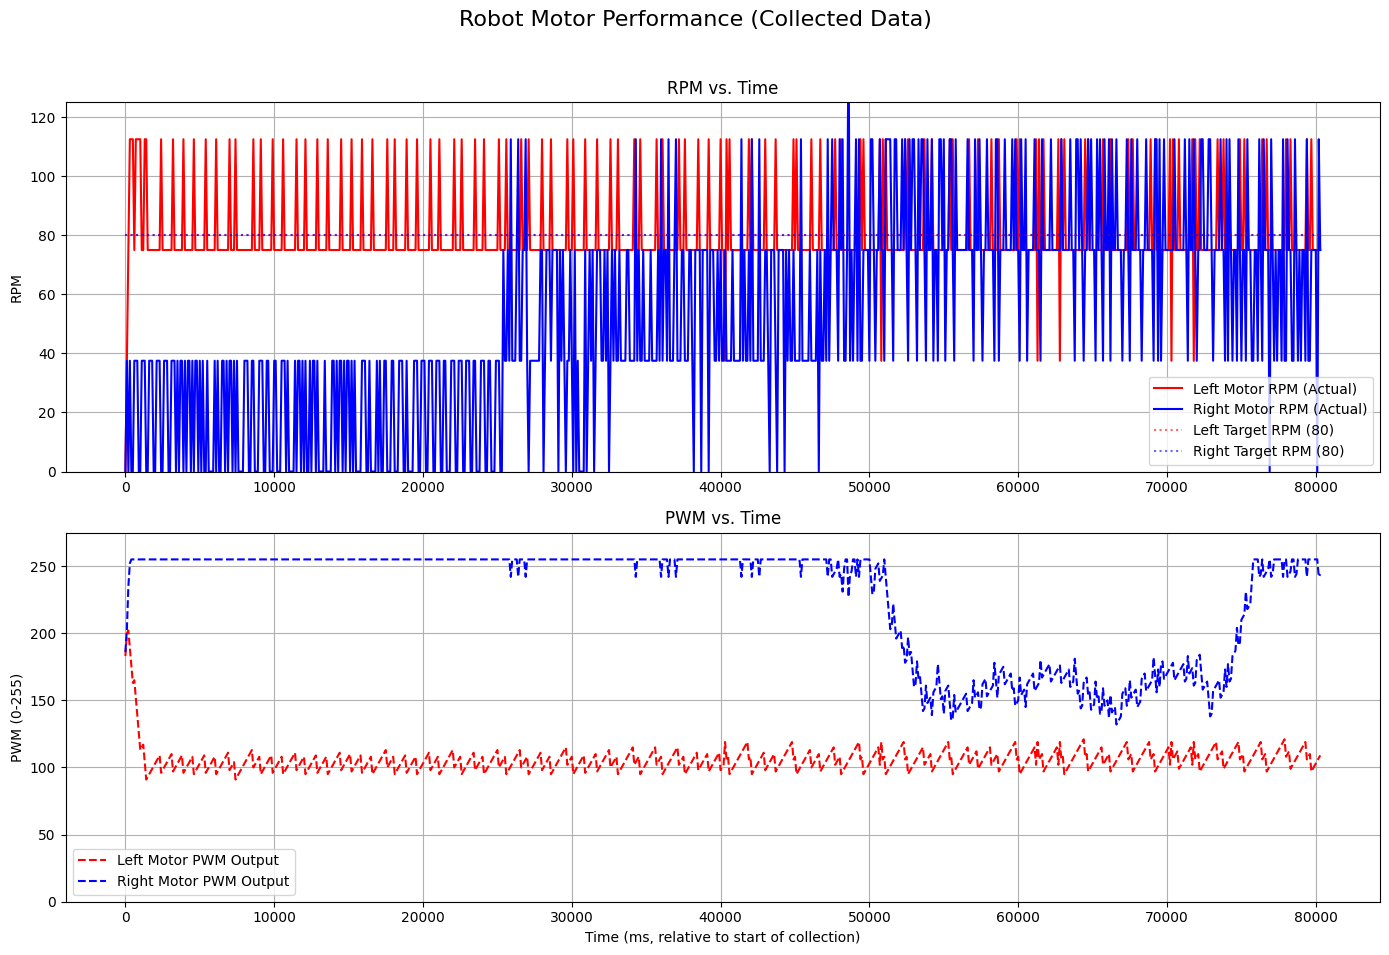

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# --- Retrieve Data from Global Variables (Populated by Cell 1) ---
# Ensure Cell 1 has been run and data has been collected
if not global_time_data:
    print("No data collected. Please run Cell 1 (Data Acquisition) first and let it collect some data.")
else:
    print(f"Plotting {len(global_time_data)} data points...")

    # Convert deques to lists if they were used in Cell 1 for any reason, though now they are lists.
    # We ensure they are numpy arrays for plotting efficiency
    plot_time = np.array(global_time_data)
    plot_rpm_left = np.array(global_rpm_left_data)
    plot_pwm_left = np.array(global_pwm_left_data)
    plot_rpm_right = np.array(global_rpm_right_data)
    plot_pwm_right = np.array(global_pwm_right_data)

    # --- Plot Setup ---
    plt.ioff() # Ensure interactive mode is off for static plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10)) # Adjusted figure size for better visibility
    fig.suptitle('Robot Motor Performance (Collected Data)', fontsize=16)

    # Plot RPMs
    ax1.plot(plot_time, plot_rpm_left, 'r-', label='Left Motor RPM (Actual)')
    ax1.plot(plot_time, plot_rpm_right, 'b-', label='Right Motor RPM (Actual)')
    
    # Add target RPM lines for reference
    if plot_time.size > 0:
        ax1.plot(plot_time, np.full_like(plot_time, 80.0), 'r:', alpha=0.6, label='Left Target RPM (80)')
        ax1.plot(plot_time, np.full_like(plot_time, 80.0), 'b:', alpha=0.6, label='Right Target RPM (80)')

    ax1.set_ylabel('RPM')
    ax1.set_title('RPM vs. Time')
    ax1.legend()
    ax1.grid(True)
    ax1.set_ylim(0, 125) # Adjust Y-limit for RPM if your target/actual RPM differs significantly

    # Plot PWMs
    ax2.plot(plot_time, plot_pwm_left, 'r--', label='Left Motor PWM Output')
    ax2.plot(plot_time, plot_pwm_right, 'b--', label='Right Motor PWM Output')

    ax2.set_xlabel('Time (ms, relative to start of collection)')
    ax2.set_ylabel('PWM (0-255)')
    ax2.set_title('PWM vs. Time')
    ax2.legend()
    ax2.grid(True)
    ax2.set_ylim(0, 275) # PWM range is 0-255

    plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to prevent title overlap
    plt.show()

